# 20151230-predict-household-income-from-census

Related post:  
https://stharrold.github.io/20151230-predict-household-income-from-census.html

Purpose: Predict total annual household income.

## Initialization

### Imports

In [1]:
cd ~

/home/samuel_harrold


In [2]:
# Import standard packages.
import collections
import functools
import json
import os
import pdb # TEST: Comment out pdb after testing.
import pprint
import sys
import time
# Import installed packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, 'stharrold.github.io/content/static/dsdemos'))
# TEST: Comment out autoreload after testing.
%reload_ext autoreload
%autoreload 2
import dsdemos as dsd
# IPython magic.
%matplotlib inline

## Globals

In [3]:
# File paths
path_static = os.path.join(os.path.expanduser(r'~'), r'stharrold.github.io/content/static')
basename = r'20151230-predict-household-income-from-census'
path_disk = os.path.abspath(r'/mnt/disk-20151227t211000z/')
path_acs = os.path.join(path_disk, r'www2-census-gov/programs-surveys/acs/')
path_pcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13pdc.csv') # 'pdc' = 'person DC'
path_hcsv = os.path.join(path_acs, r'data/pums/2013/5-Year/ss13hdc.csv') # 'hdc' = 'housing DC'
path_ecsv = os.path.join(path_acs, r'tech_docs/pums/estimates/pums_estimates_9_13.csv')
path_dtxt = os.path.join(path_acs, r'tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt')
# Weights
pwt = 'PWGTP' # person weight
pwts = [pwt+str(inum) for inum in range(1, 81)]
hwt = 'WGTP' # housing weight
hwts = [hwt+str(inum) for inum in range(1, 81)]
# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract-transform-load

**TODO:**
* Just use pandas. Acknowledge dask.

### PUMS data

https://www.census.gov/programs-surveys/acs/data/data-via-ftp.html

http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/ss13pdc.csv

http://www2.census.gov/programs-surveys/acs/data/pums/2013/5-Year/ss13hdc.csv

In [4]:
time_start = time.perf_counter()
for path in [path_pcsv, path_hcsv]:
    with open(path) as fobj:
        nlines = sum(1 for _ in fobj)
    print("{path}:".format(path=path))
    print("    size (MB) = {size:.1f}".format(size=os.path.getsize(path)/1e6))
    print("    num lines = {nlines}".format(nlines=nlines))
print()
dfp = pd.read_csv(path_pcsv)
dfh = pd.read_csv(path_hcsv)
for (name, df) in [('dfp', dfp), ('dfh', dfh)]:
    print("{name} RAM usage (MB) = {mem:.1f}".format(
            name=name, mem=df.memory_usage().sum()/1e6))
time_stop = time.perf_counter()
print()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

/mnt/disk-20151227t211000z/www2-census-gov/programs-surveys/acs/data/pums/2013/5-Year/ss13pdc.csv:
    size (MB) = 30.5
    num lines = 30560
/mnt/disk-20151227t211000z/www2-census-gov/programs-surveys/acs/data/pums/2013/5-Year/ss13hdc.csv:
    size (MB) = 13.5
    num lines = 17501

dfp RAM usage (MB) = 72.1
dfh RAM usage (MB) = 28.7

Time elapsed (sec) = 1.6


/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (107,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(dfp.columns.values)
dfp.head()

['RT' 'SERIALNO' 'SPORDER' 'PUMA00' 'PUMA10' 'ST' 'ADJINC' 'PWGTP' 'AGEP'
 'CIT' 'CITWP05' 'CITWP12' 'COW' 'DDRS' 'DEAR' 'DEYE' 'DOUT' 'DPHY' 'DRAT'
 'DRATX' 'DREM' 'ENG' 'FER' 'GCL' 'GCM' 'GCR' 'HINS1' 'HINS2' 'HINS3'
 'HINS4' 'HINS5' 'HINS6' 'HINS7' 'INTP' 'JWMNP' 'JWRIP' 'JWTR' 'LANX' 'MAR'
 'MARHD' 'MARHM' 'MARHT' 'MARHW' 'MARHYP05' 'MARHYP12' 'MIG' 'MIL' 'MLPA'
 'MLPB' 'MLPCD' 'MLPE' 'MLPFG' 'MLPH' 'MLPI' 'MLPJ' 'MLPK' 'NWAB' 'NWAV'
 'NWLA' 'NWLK' 'NWRE' 'OIP' 'PAP' 'RELP' 'RETP' 'SCH' 'SCHG' 'SCHL' 'SEMP'
 'SEX' 'SSIP' 'SSP' 'WAGP' 'WKHP' 'WKL' 'WKW' 'WRK' 'YOEP05' 'YOEP12' 'ANC'
 'ANC1P05' 'ANC1P12' 'ANC2P05' 'ANC2P12' 'DECADE' 'DIS' 'DRIVESP' 'ESP'
 'ESR' 'FOD1P' 'FOD2P' 'HICOV' 'HISP' 'INDP' 'JWAP' 'JWDP' 'LANP05'
 'LANP12' 'MIGPUMA00' 'MIGPUMA10' 'MIGSP05' 'MIGSP12' 'MSP' 'NAICSP'
 'NATIVITY' 'NOP' 'OC' 'OCCP02' 'OCCP10' 'OCCP12' 'PAOC' 'PERNP' 'PINCP'
 'POBP05' 'POBP12' 'POVPIP' 'POWPUMA00' 'POWPUMA10' 'POWSP05' 'POWSP12'
 'PRIVCOV' 'PUBCOV' 'QTRBIR' 'RAC1P' 'RAC2P05' 'RAC2P

,RT,SERIALNO,SPORDER,PUMA00,PUMA10,ST,ADJINC,PWGTP,AGEP,CIT,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2009000000403,1,102,-9,11,1085467,20,38,1,...,6,26,31,32,26,6,36,6,19,20
1,P,2009000001113,1,103,-9,11,1085467,13,78,1,...,13,30,12,13,4,4,18,24,4,21
2,P,2009000001113,2,103,-9,11,1085467,25,39,1,...,26,50,23,20,8,7,38,41,7,37
3,P,2009000001113,3,103,-9,11,1085467,17,8,1,...,15,32,17,15,6,4,26,32,5,30
4,P,2009000001978,1,103,-9,11,1085467,37,53,1,...,65,12,13,37,36,41,57,36,11,33


In [6]:
print(dfh.columns.values)
dfh.head()

['insp' 'RT' 'SERIALNO' 'DIVISION' 'PUMA00' 'PUMA10' 'REGION' 'ST' 'ADJHSG'
 'ADJINC' 'WGTP' 'NP' 'TYPE' 'ACR' 'AGS' 'BATH' 'BDSP' 'BLD' 'BUS' 'CONP'
 'ELEP' 'FS' 'FULP' 'GASP' 'HFL' 'MHP' 'MRGI' 'MRGP' 'MRGT' 'MRGX' 'REFR'
 'RMSP' 'RNTM' 'RNTP' 'RWAT' 'RWATPR' 'SINK' 'SMP' 'STOV' 'TEL' 'TEN'
 'TOIL' 'VACS' 'VALP' 'VEH' 'WATP' 'YBL' 'FES' 'FINCP' 'FPARC' 'GRNTP'
 'GRPIP' 'HHL' 'HHT' 'HINCP' 'HUGCL' 'HUPAC' 'HUPAOC' 'HUPARC' 'KIT' 'LNGI'
 'MULTG' 'MV' 'NOC' 'NPF' 'NPP' 'NR' 'NRC' 'OCPIP' 'PARTNER' 'PLM' 'PSF'
 'R18' 'R60' 'R65' 'RESMODE' 'SMOCP' 'SMX' 'SRNT' 'SVAL' 'TAXP' 'WIF'
 'WKEXREL' 'WORKSTAT' 'FACRP' 'FAGSP' 'FBATHP' 'FBDSP' 'FBLDP' 'FBUSP'
 'FCONP' 'FELEP' 'FFSP' 'FFULP' 'FGASP' 'FHFLP' 'FINSP' 'FKITP' 'FMHP'
 'FMRGIP' 'FMRGP' 'FMRGTP' 'FMRGXP' 'FMVP' 'FPLMP' 'FREFRP' 'FRMSP'
 'FRNTMP' 'FRNTP' 'FRWATP' 'FRWATPRP' 'FSINKP' 'FSMP' 'FSMXHP' 'FSMXSP'
 'FSTOVP' 'FTAXP' 'FTELP' 'FTENP' 'FTOILP' 'FVACSP' 'FVALP' 'FVEHP' 'FWATP'
 'FYBLP' 'WGTP1' 'WGTP2' 'WGTP3' 'WGTP4' 'WGTP5' 'WGTP6' '

,insp,RT,SERIALNO,DIVISION,PUMA00,PUMA10,REGION,ST,ADJHSG,ADJINC,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,600,H,2009000000403,5,102,-9,3,11,1086032,1085467,...,6,25,30,32,26,6,36,6,18,19
1,NaN,H,2009000001113,5,103,-9,3,11,1086032,1085467,...,14,29,12,12,4,4,18,23,4,22
2,480,H,2009000001978,5,103,-9,3,11,1086032,1085467,...,65,12,14,37,36,41,57,36,11,34
3,NaN,H,2009000002250,5,105,-9,3,11,1086032,1085467,...,4,4,4,4,23,14,11,4,20,21
4,2500,H,2009000002985,5,101,-9,3,11,1086032,1085467,...,66,45,10,35,34,10,34,55,50,10


### PUMS estimates for user verification

Documentation page:
https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html

User verification files:
http://www2.census.gov/programs-surveys/acs/tech_docs/pums/estimates/pums_estimates_9_13.csv

For general purpose information:  
http://www2.census.gov/programs-surveys/acs/tech_docs/pums/ACS2009_2013_PUMS_README.pdf  

For accuracy error formulas and inflation adjustments:
http://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2009_2013AccuracyPUMS.pdf

Handbook of guidelines for ACS PUMS:
https://www.census.gov/content/dam/Census/library/publications/2009/acs/ACSPUMS.pdf

Design and Methodology report for details on how Census Bureau designs and reports the survey:
https://www.census.gov/programs-surveys/acs/methodology/design-and-methodology.html

PDFs above cover:  
ACS uses weights samples '[P]WGTP' to mitigate over/under-representation and to control for agreement with other ACS estimates. The [ACCURACY PDF] describe two ways of calculating the uncertianties associated with estimates (also called "characteristics", e.g. total population, total households) from these weighted samples:
1. Calculate the "generalized standard error" of the estimate using "design factors" from the survey. This is a single calculation and requires looking up a design factor for the estimate (characteristic).  
2. Calculate the "direct standard error" of the estimate using per-sample "replicate weights" '[P]WGTP[1-80]'. This is multiple combined calculations but is extensible to many estimates. (Footnote: Controlled estimates like "total population" will have 0 direct standard error from replicate weights. Use the generalized standard error for these estimates or calculate them numerically by sampling with replacement.)

TODO: mention sampling stats in stats for hackers

In [7]:
dfe = pd.read_csv(path_ecsv)
tfmask = dfe['state'] == 'District of Columbia'
dfe_dc = dfe.loc[tfmask]
dfe_dc

,st,state,characteristic,pums_est_09_to_13,pums_se_09_to_13,pums_moe_09_to_13
288,11,District of Columbia,Total population,"619,371",0,0
289,11,District of Columbia,Housing unit population (RELP=0-15),"579,281",0,0
290,11,District of Columbia,GQ population (RELP=16-17),"40,090",0,0
291,11,District of Columbia,GQ institutional population (RELP=16),"7,443",80,132
292,11,District of Columbia,GQ noninstitutional population (RELP=17),"32,647",80,132
293,11,District of Columbia,Total males (SEX=1),"292,566",361,595
294,11,District of Columbia,Total females (SEX=2),"326,805",361,595
295,11,District of Columbia,Age 0-4,"36,530",253,417
296,11,District of Columbia,Age 5-9,"27,658",636,1046
297,11,District of Columbia,Age 10-14,"24,621",598,984


In [8]:
cols = ['characteristic', 'pums_est_09_to_13', 'pums_se_09_to_13', 'pums_moe_09_to_13']

In [9]:
# TODO: Move to dsdemos with tests.
print("Verify:")
records_dfs = {
    'PERSON RECORD':  {'dataframe': dfp, 'weight': pwt, 'replicate_weights': pwts},
    'HOUSING RECORD': {'dataframe': dfh, 'weight': hwt, 'replicate_weights': hwts}}
tfmask_test_strs = collections.OrderedDict([
    ('PERSON RECORD', collections.OrderedDict([
        ('Total population', "np.asarray([True]*len(dfp))"),
        ('Housing unit population (RELP=0-15)',"np.logical_and(0 <= dfp['RELP'], dfp['RELP'] <= 15)"),
        ('GQ population (RELP=16-17)', "np.logical_and(16 <= dfp['RELP'], dfp['RELP'] <= 17)"),
        ('GQ institutional population (RELP=16)', "dfp['RELP'] == 16"),
        ('GQ noninstitutional population (RELP=17)', "dfp['RELP'] == 17"),
        ('Total males (SEX=1)', "dfp['SEX'] == 1"),
        ('Total females (SEX=2)', "dfp['SEX'] == 2"),
        ('Age 0-4', "np.logical_and(0 <= dfp['AGEP'], dfp['AGEP'] <= 4)"),
        ('Age 5-9', "np.logical_and(5 <= dfp['AGEP'], dfp['AGEP'] <= 9)"),
        ('Age 10-14', "np.logical_and(10 <= dfp['AGEP'], dfp['AGEP'] <= 14)"),
        ('Age 15-19', "np.logical_and(15 <= dfp['AGEP'], dfp['AGEP'] <= 19)"),
        ('Age 20-24', "np.logical_and(20 <= dfp['AGEP'], dfp['AGEP'] <= 24)"),
        ('Age 25-34', "np.logical_and(25 <= dfp['AGEP'], dfp['AGEP'] <= 34)"),
        ('Age 35-44', "np.logical_and(35 <= dfp['AGEP'], dfp['AGEP'] <= 44)"),
        ('Age 45-54', "np.logical_and(45 <= dfp['AGEP'], dfp['AGEP'] <= 54)"),
        ('Age 55-59', "np.logical_and(55 <= dfp['AGEP'], dfp['AGEP'] <= 59)"),
        ('Age 60-64', "np.logical_and(60 <= dfp['AGEP'], dfp['AGEP'] <= 64)"),
        ('Age 65-74', "np.logical_and(65 <= dfp['AGEP'], dfp['AGEP'] <= 74)"),
        ('Age 75-84', "np.logical_and(75 <= dfp['AGEP'], dfp['AGEP'] <= 84)"),
        ('Age 85 and over', "85 <= dfp['AGEP']")])),
    ('HOUSING RECORD', collections.OrderedDict([
        ('Total housing units (TYPE=1)', "dfh['TYPE'] == 1"),
        ('Total occupied units', "dfh['TEN'].notnull()"),
        ('Owner occupied units (TEN in 1,2)', "np.logical_or(dfh['TEN'] == 1, dfh['TEN'] == 2)"),
        ('Renter occupied units (TEN in 3,4)', "np.logical_or(dfh['TEN'] == 3, dfh['TEN'] == 4)"),
        ('Owned with a mortgage (TEN=1)', "dfh['TEN'] == 1"),
        ('Owned free and clear (TEN=2)', "dfh['TEN'] == 2"),
        ('Rented for cash (TEN=3)', "dfh['TEN'] == 3"),
        ('No cash rent (TEN=4)', "dfh['TEN'] == 4"),
        ('Total vacant units', "dfh['TEN'].isnull()"),
        ('For rent (VACS=1)', "dfh['VACS'] == 1"),
        ('For sale only (VACS=3)', "dfh['VACS'] == 3"),
        ('All Other Vacant (VACS in 2,4,5,6,7)',
         "functools.reduce(np.logical_or, (dfh['VACS'] == vacs for vacs in [2,4,5,6,7]))")]))])
for record_type in records_dfs:
    print("'{rt}'".format(rt=record_type))
    df = records_dfs[record_type]['dataframe']
    wt = records_dfs[record_type]['weight']
    wts = records_dfs[record_type]['replicate_weights']
    for char in tfmask_test_strs[record_type]:
        print("    '{char}'".format(char=char))
        tfmask_ref = dfe_dc['characteristic'] == char        
        tfmask_test = eval(tfmask_test_strs[record_type][char])
        # Calculate an estimate ('est', also a "characteristic"),
        # a weighted sum, using sample weights '[P]WGTP'.
        col = 'pums_est_09_to_13'
        print("        '{col}':".format(col=col), end=' ')
        ref_est = int(dfe_dc.loc[tfmask_ref, col].values[0].replace(',', ''))
        test_est = df.loc[tfmask_test, wt].sum()
        assert ref_est == test_est
        print("(ref, test) = {tup}".format(tup=(ref_est, test_est)))
        # Calculate a direct standard error ('se') using replicate weights '[P]WGTP[1-80]'.
        # http://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2009_2013AccuracyPUMS.pdf
        # section 7, "Measuring Sampling Error"
        col = 'pums_se_09_to_13'
        print("        '{col}':".format(col=col), end=' ')
        ref_se = dfe_dc.loc[tfmask_ref, col].values[0]
        test_se = ((4/80)*((df.loc[tfmask_test, wts].sum() - test_est)**2).sum())**0.5
        assert np.isclose(ref_se, test_se, rtol=0, atol=1)
        print("(ref, test) = {tup}".format(tup=(ref_se, test_se)))
        # Calculate a margin of error ('moe') at the 90% confidence level (+/- 1.645 standard errors)
        # http://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2009_2013AccuracyPUMS.pdf
        # section 7, "Measuring Sampling Error"
        col = 'pums_moe_09_to_13'
        print("        '{col}'".format(col=col), end=' ')
        ref_moe = dfe_dc.loc[tfmask_ref, col].values[0]
        test_moe = 1.645*test_se
        assert np.isclose(ref_moe, test_moe, rtol=0, atol=1)
        print("(ref, test) = {tup}".format(tup=(ref_moe, test_moe)))

Verify:
'PERSON RECORD'
    'Total population'
        'pums_est_09_to_13': (ref, test) = (619371, 619371)
        'pums_se_09_to_13': (ref, test) = (0, 0.0)
        'pums_moe_09_to_13' (ref, test) = (0, 0.0)
    'Housing unit population (RELP=0-15)'
        'pums_est_09_to_13': (ref, test) = (579281, 579281)
        'pums_se_09_to_13': (ref, test) = (0, 0.0)
        'pums_moe_09_to_13' (ref, test) = (0, 0.0)
    'GQ population (RELP=16-17)'
        'pums_est_09_to_13': (ref, test) = (40090, 40090)
        'pums_se_09_to_13': (ref, test) = (0, 0.0)
        'pums_moe_09_to_13' (ref, test) = (0, 0.0)
    'GQ institutional population (RELP=16)'
        'pums_est_09_to_13': (ref, test) = (7443, 7443)
        'pums_se_09_to_13': (ref, test) = (80, 80.30971298666184)
        'pums_moe_09_to_13' (ref, test) = (132, 132.10947786305871)
    'GQ noninstitutional population (RELP=17)'
        'pums_est_09_to_13': (ref, test) = (32647, 32647)
        'pums_se_09_to_13': (ref, test) = (80, 80.30971

In [61]:
record_type = 'PERSON RECORD'
print("'{rt}'".format(rt=record_type))
df = records_dfs[record_type]['dataframe']
wt = records_dfs[record_type]['weight']
wts = records_dfs[record_type]['replicate_weights']
char = 'GQ institutional population (RELP=16)'
print("    '{char}'".format(char=char))
tfmask_ref = dfe_dc['characteristic'] == char        
tfmask_test = eval(tfmask_test_strs[record_type][char])
# Calculate an estimate ('est', also a "characteristic"),
# a weighted sum, using sample weights '[P]WGTP'.
col = 'pums_est_09_to_13'
print("        '{col}':".format(col=col), end=' ')
ref_est = int(dfe_dc.loc[tfmask_ref, col].values[0].replace(',', ''))
test_est = df.loc[tfmask_test, wt].sum()
assert ref_est == test_est
print("(ref, test) = {tup}".format(tup=(ref_est, test_est)))
# Calculate a direct standard error ('se') using replicate weights '[P]WGTP[1-80]'.
# http://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2009_2013AccuracyPUMS.pdf
# section 7, "Measuring Sampling Error"
col = 'pums_se_09_to_13'
print("        '{col}':".format(col=col), end=' ')
ref_se = dfe_dc.loc[tfmask_ref, col].values[0]
test_se = ((4/80)*((df.loc[tfmask_test, wts].sum() - test_est)**2).sum())**0.5
assert np.isclose(ref_se, test_se, rtol=0, atol=1)
print("(ref, test) = {tup}".format(tup=(ref_se, test_se)))
# Calculate a margin of error ('moe') at the 90% confidence level (+/- 1.645 standard errors)
# http://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2009_2013AccuracyPUMS.pdf
# section 7, "Measuring Sampling Error"
col = 'pums_moe_09_to_13'
print("        '{col}'".format(col=col), end=' ')
ref_moe = dfe_dc.loc[tfmask_ref, col].values[0]
test_moe = 1.645*test_se
assert np.isclose(ref_moe, test_moe, rtol=0, atol=1)
print("(ref, test) = {tup}".format(tup=(ref_moe, test_moe)))

'PERSON RECORD'
    'GQ institutional population (RELP=16)'
        'pums_est_09_to_13': (ref, test) = (7443, 7443)
        'pums_se_09_to_13': (ref, test) = (80, 80.30971298666184)
        'pums_moe_09_to_13' (ref, test) = (132, 132.10947786305871)


In [12]:
tfmask_test

613

In [56]:
import astroML.plotting as astroML_plt
import seaborn as sns
sns.set() # Set matplotlib styles with seaborn

/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Try getting sum errors 1

sum(values) = 7443


/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


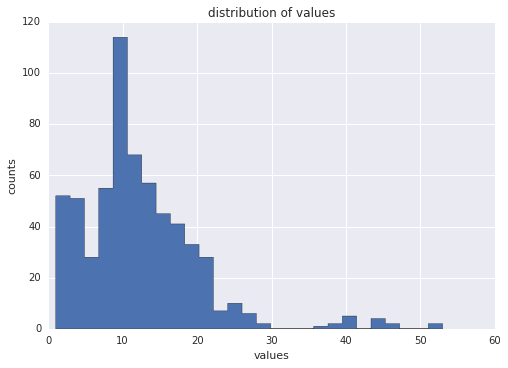

In [76]:
dist = df.loc[tfmask_test, wt]
pmf = dist.values / dist.sum()
assert np.isclose(np.sum(pmf), 1.0)
fracs = [0.01, 0.1, 0.2, 0.33, 0.5, 0.67, 0.8, 0.9, 0.99]
print("sum(values) = {sm}".format(sm=dist.sum()))
plt.title("distribution of values")
astroML_plt.hist(
    dist.values, bins='knuth', histtype='stepfilled',
    color=sns.color_palette()[0])
plt.xlabel('values')
plt.ylabel('counts')
plt.savefig(os.path.join(os.path.expanduser('~'), 'dist.png'))
plt.show()

################################################################################
sample_with_replacement=True, sample_weighted=True
0.01 0.1 0.2 0.33 0.5 0.67 0.8 0.9 0.99 
Elapsed time (sec) = 20.41


/home/samuel_harrold/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


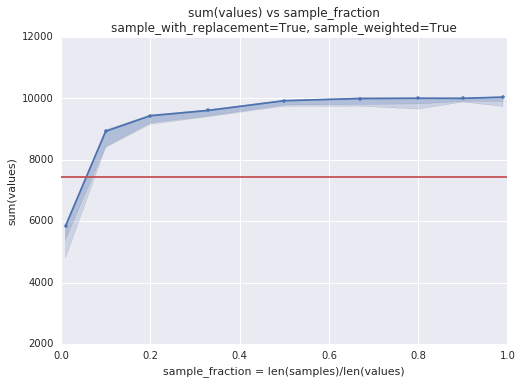

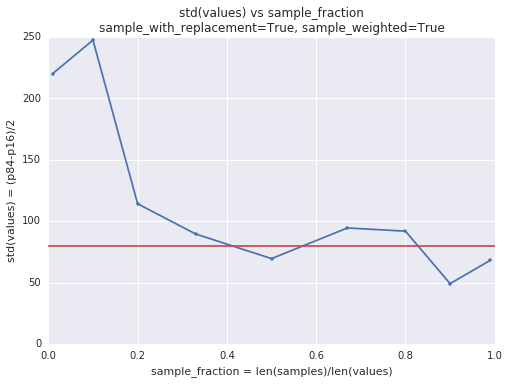

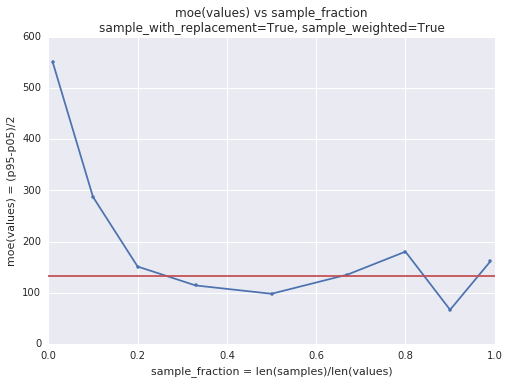

################################################################################
sample_with_replacement=True, sample_weighted=False
0.01 0.1 0.2 0.33 0.5 0.67 0.8 0.9 0.99 
Elapsed time (sec) = 9.24


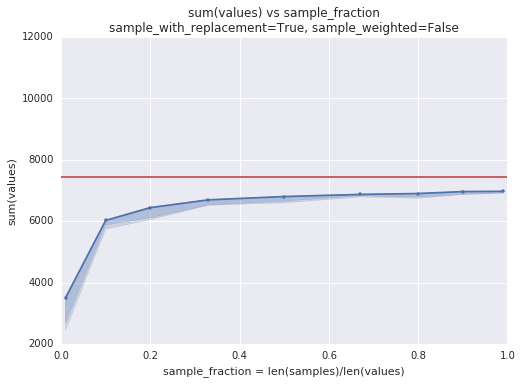

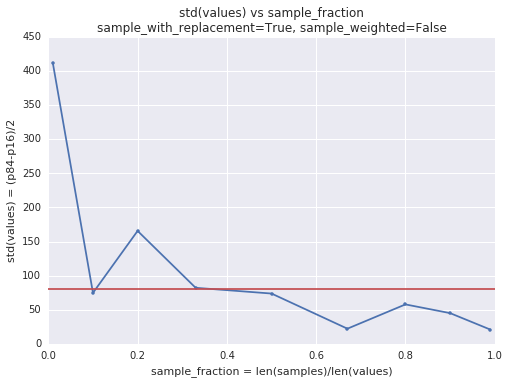

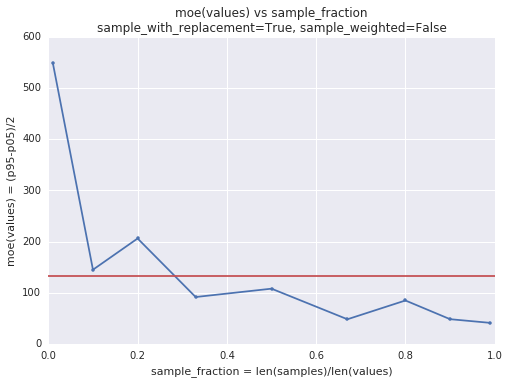

################################################################################
sample_with_replacement=False, sample_weighted=True
0.01 0.1 0.2 0.33 0.5 0.67 0.8 0.9 0.99 
Elapsed time (sec) = 23.34


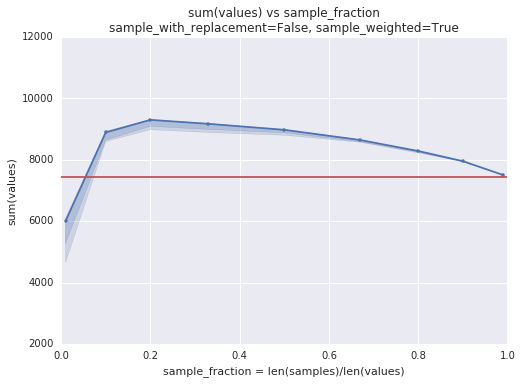

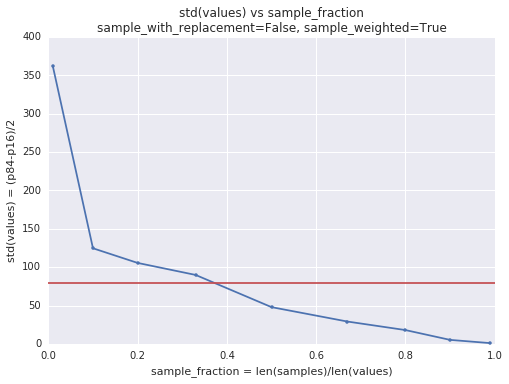

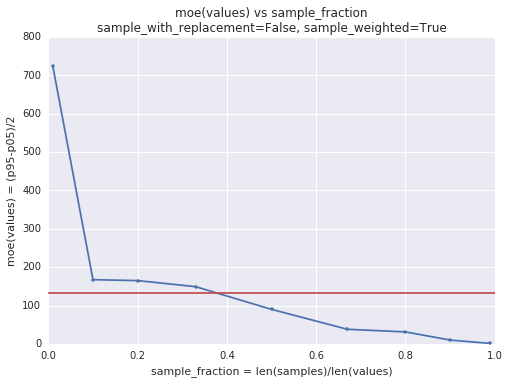

################################################################################
sample_with_replacement=False, sample_weighted=False
0.01 0.1 0.2 0.33 0.5 0.67 0.8 0.9 0.99 
Elapsed time (sec) = 10.68


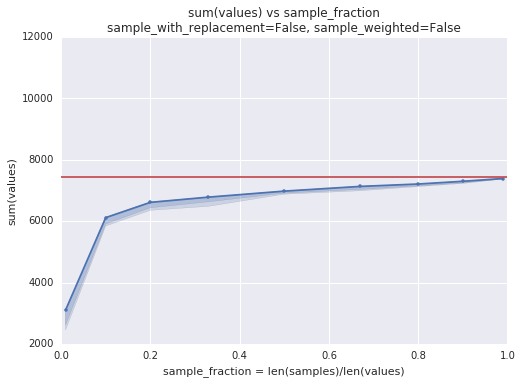

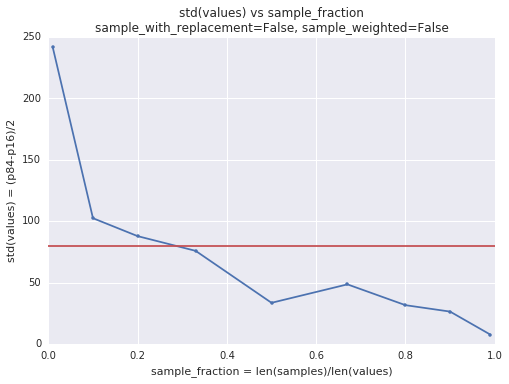

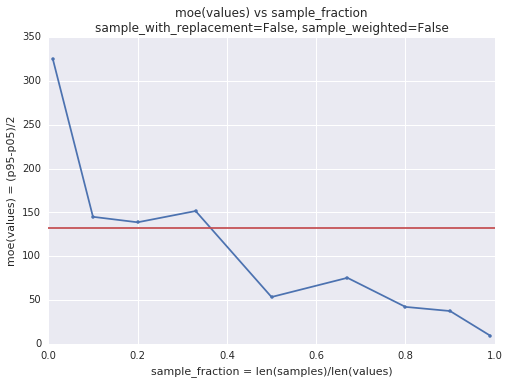

In [79]:
for replace in [True, False]:
    for has_weights in [True, False]:
        print('#'*80)
        print(("sample_with_replacement={re}, sample_weighted={hw}").format(
            re=replace, hw=has_weights))
        if has_weights:
            weights = pmf
        else:
            weights = None
        time_start = time.perf_counter()
        pct_arr = list()
        for frac in fracs:
            print(frac, end=' ')
            pct_arr.append(
                np.percentile(
                    a=[(1/frac)*dist.sample(
                        frac=frac, replace=replace, weights=weights, random_state=None).sum()
                        for _ in range(int(1e3))],
                    q=percentiles))
        pct_arr = np.asarray(pct_arr)
        time_stop = time.perf_counter()
        print("\nElapsed time (sec) = {diff:.2f}".format(diff=time_stop-time_start))
        xlabel = "sample_fraction = len(samples)/len(values)"
        plt.title(
            ("sum(values) vs sample_fraction\n" +
             "sample_with_replacement={re}, sample_weighted={hw}").format(
                re=replace, hw=has_weights))
        plt.xlabel(xlabel)
        plt.ylabel("sum(values)")
        plt.fill_between(fracs, y1=pct_arr[:, 0], y2=pct_arr[:, -1], alpha=0.2)
        plt.fill_between(fracs, y1=pct_arr[:, 1], y2=pct_arr[:, -2], alpha=0.2)
        plt.plot(fracs, pct_arr[:, 3], marker='.')
        plt.axhline(y=ref_est, color=sns.color_palette()[2])
        plt.ylim(2e3, 12e3)
        plt.show()
        plt.title(
            ("std(values) vs sample_fraction\n" +
             "sample_with_replacement={re}, sample_weighted={hw}").format(
                re=replace, hw=has_weights))
        plt.xlabel(xlabel)
        plt.ylabel("std(values) = (p84-p16)/2")
        plt.plot(fracs, (pct_arr[:, -2]-pct_arr[:, 1])/2, marker='.')
        plt.axhline(y=ref_se, color=sns.color_palette()[2])
        plt.show()
        plt.title(
            ("moe(values) vs sample_fraction\n" +
             "sample_with_replacement={re}, sample_weighted={hw}").format(
                re=replace, hw=has_weights))
        plt.xlabel(xlabel)
        plt.ylabel("moe(values) = (p95-p05)/2")
        plt.plot(fracs, (pct_arr[:, -1]-pct_arr[:, 0])/2, marker='.')
        plt.axhline(y=ref_moe, color=sns.color_palette()[2])
        plt.show()

In [77]:
percentiles

[0.05, 0.1587, 0.5, 0.8413, 0.95]

### test weighting

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

average =  500.0
weighted average =  667.0

Elapsed time (sec) = 0.0306


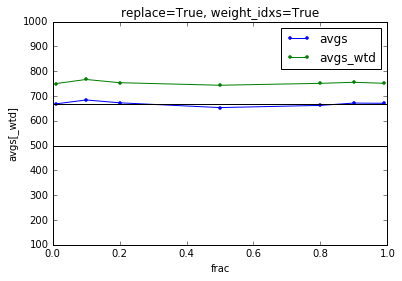


Elapsed time (sec) = 0.0009


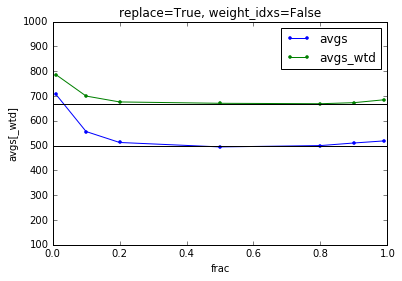


Elapsed time (sec) = 0.0066


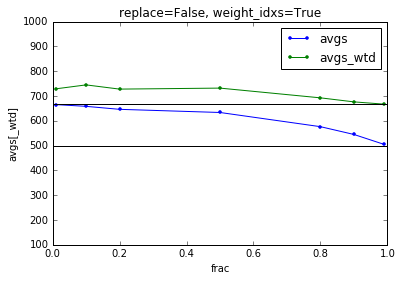


Elapsed time (sec) = 0.0023


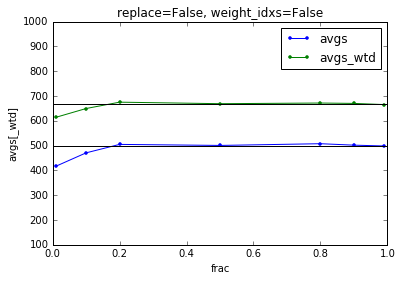

In [2]:
# Summary for averages: replace=True, weight_idxs=False is accurate and fast.
vals = np.arange(1001)
pmf = vals / np.sum(vals) # probability mass function
assert np.isclose(np.sum(pmf), 1.0)
ref_avg = np.average(vals)
ref_avg_wtd = np.average(vals, weights=pmf)
print('average = ', ref_avg)
print('weighted average = ', ref_avg_wtd)
fracs = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
for replace in [True, False]:
    for weight_idxs in [True, False]:
        if weight_idxs:
            wts = pmf
        else:
            wts = None
        time_start = time.perf_counter()
        (avgs, avgs_wtd) = (list(), list())
        for frac in fracs:
            size = round(frac*len(vals))
            idxs = np.random.choice(vals, size=size, replace=replace, p=wts)
            avgs.append(np.average(vals[idxs]))
            avgs_wtd.append(np.average(vals[idxs], weights=pmf[idxs]))
        time_stop = time.perf_counter()
        print("\nElapsed time (sec) = {diff:.4f}".format(diff=time_stop - time_start))
        plt.title("replace={re}, weight_idxs={hw}".format(
                re=replace, hw=weight_idxs))
        plt.xlabel("frac")
        plt.ylabel("avgs[_wtd]")
        plt.plot(fracs, avgs, marker='.', color='blue', label='avgs')
        plt.plot(fracs, avgs_wtd, marker='.', color='green', label='avgs_wtd')
        plt.axhline(ref_avg, color='black')
        plt.axhline(ref_avg_wtd, color='black')
        plt.ylim(1e2, 1e3)
        plt.legend()
        plt.show()        

In [4]:
# Summary for sums: replace=_, weight_idxs=_ is accurate and fast.
vals = np.arange(1001)
ref_count = len(vals)
ref_sum = np.sum(vals)
print('count = ', ref_count)
print('sum = ', ref_sum)

count =  1001
sum =  500500



Elapsed time (sec) = 0.0015


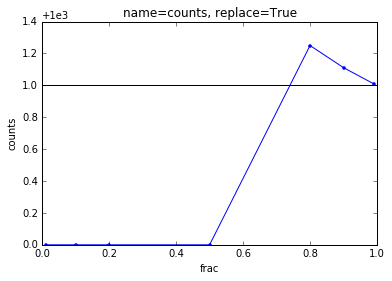

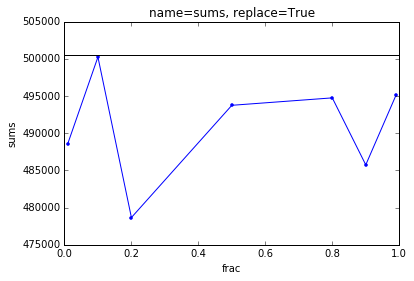


Elapsed time (sec) = 0.0022


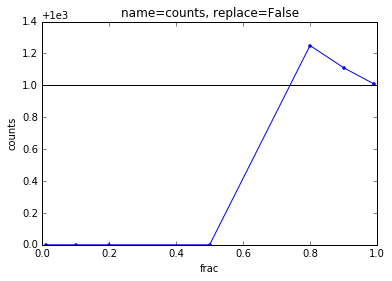

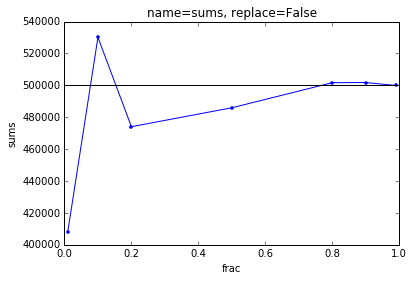

In [6]:
fracs = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
for replace in [True, False]:
    time_start = time.perf_counter()
    (counts, sums) = (list(), list())
    for frac in fracs:
        size = round(frac*len(vals))
        idxs = np.random.choice(vals, size=size, replace=replace, p=None)
        counts.append((1/frac)*len(vals[idxs]))
        sums.append((1/frac)*np.sum(vals[idxs]))
    time_stop = time.perf_counter()
    print("\nElapsed time (sec) = {diff:.4f}".format(diff=time_stop - time_start))
    for (name, arr) in [('counts', counts), ('sums', sums)]:
        if name == 'counts':
            (arr, ref) = (counts, ref_count)
        else:
            (arr, ref) = (sums, ref_sum)
        plt.title("name={nm}, replace={re}".format(nm=name, re=replace))
        plt.xlabel("frac")
        plt.ylabel(name)
        plt.plot(fracs, arr, marker='.')
        plt.axhline(ref, color='black')
        plt.show()        

In [8]:
counts

[1000.0,
 1000.0,
 1000.0,
 1000.0,
 1001.25,
 1001.1111111111112,
 1001.010101010101]

### Data dictionary

https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html

http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2009-2013.txt

In [6]:
ddict = parse_pumsdatadict(path=path_dtxt)

length  \
record_type    var_name          
HOUSING RECORD ACCESS        1   
               ACR           1   
               ADJHSG        7   
               ADJINC        7   
               AGS           1   

                                                               description  \
record_type    var_name                                                      
HOUSING RECORD ACCESS                               Access to the Internet   
               ACR                                                Lot size   
               ADJHSG    Adjustment factor for housing dollar amounts (...   
               ADJINC    Adjustment factor for income and earnings doll...   
               AGS            Sales of Agriculture Products (Yearly sales)   

                                                                 var_codes  \
record_type    var_name                                                      
HOUSING RECORD ACCESS    {'b': 'N/A (GQ)', '1': 'Yes, with subscription...   
               ACR       {'b': 'N/A (GQ/not a one-family house or mobil...   
               ADJHSG                {'1000000': '2013 factor (1.000000)'}   
               ADJINC                {'1007549': '2013 factor (1.007549)'}   
               AGS       {'b': 'N/A (GQ/vacant/not a one family house o...   

                                                                     notes  
record_type    var_name                                                     
HOUSING RECORD ACCESS                                                  NaN  
               ACR                                                     NaN  
               ADJHSG    [Note: The value of ADJHSG inflation-adjusts r...  
               ADJINC    [Note: The value of ADJINC inflation-adjusts r...  
               AGS         [Note: no adjustment factor is applied to AGS.]

## Select features

**Notes:**
* Example consumer databases: http://www.consumerreports.org/cro/money/consumer-protection/big-brother-is-watching/overview/index.htm?rurl=http%3A%2F%2Fwww.consumerreports.org%2Fcro%2Fmoney%2Fconsumer-protection%2Fbig-brother-is-watching%2Foverview%2Findex.htm
* Random forests are scale invariant, so they can accommodate non-linear transformation.
* Cast all values to floats so that compatable with most algorithms and can use </> logic. Otherwise less informationally dense and may require deeper tree structure to find features.
* To "map to float" ('b' is N/A, mapped to 0; 1 is Yes; 2 is No; other values are special):  
```python
test = pd.DataFrame(data=[['  b', 1.0], ['1', 1.0], ['2', 1.0], ['3', 1.1], ['4', 1.1]], columns=['COL', 'ADJ'])
tfmask = test['COL'].str.contains('b')
test.loc[tfmask, 'COL'] = 0.0
test['COL'] = test['COL'].astype(float)
print(test.dtypes)
test
```
* To "adjust for inflation":  
```python
test['ADJ'] *= 1e-6
tfmask = test['COL'] >= 3.0
test.loc[tfmask, 'COL'] *= test.loc[tfmask, 'ADJ']
test
```
* TODO: Remove vacant units ('NP') from data frame.
* TODO: Filter categorical variables from metadata (those without '..').

In [66]:
record_type = 'PERSON RECORD'
print_detail = False
for key in ddict['record_types'][record_type]:
    desc = ddict['record_types'][record_type][key]['description']
    if not (
        (key.startswith('F') and (desc.endswith(' flag') or desc.endswith(' edit')))
        or ('WGTP' in key and "Weight replicate" in desc)):
        if print_detail:
            print(key)
            pprint.pprint(ddict['record_types'][record_type][key])
        else:
            print("{key}: {desc}".format(key=key, desc=desc))

RT: Record Type
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data Collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
PWGTP: Person's weight
AGEP: Age
CIT: Citizenship status
CITWP05: Year of naturalization write-in for data collected prior to 2012
CITWP12: Year of naturalization write-in for data collected in 2012 or later
COW: Class of worker
DDRS: Self-care difficulty
DEAR: Hearing difficulty
DEYE: Vision difficulty
DOUT: Independent living difficulty
DPHY: Ambulatory difficulty
DRAT: Veteran service connected disability rating (percentage)
DRATX: Veteran service connected disability rating (checkbox)
DREM: Cognitive diffic

In [85]:
# Include columns that I think companies can easily get.
# for column details: https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2013.html
# target: HINCP

cols_include = {
    'HOUSING RECORD': [
        'SERIALNO', 'PUMA00', 'PUMA10', 'ST', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'BDSP', 'BLD', 'HINCP', 'R18', 'R65'],
    'PERSON RECORD': [
        'SERIALNO', 'SPORDER', 'PWGTP', 'AGEP', 'MAR', 'SCHL', 'INDP']
    }

In [86]:
for record_type in cols_include:
    print(record_type)
    for var_name in cols_include[record_type]:
        desc = ddict['record_types'][record_type][var_name]['description']
        print("{var}: {desc}".format(var=var_name, desc=desc))
    print()

HOUSING RECORD
SERIALNO: Housing unit/GQ person serial number
PUMA00: Public use microdata area code (PUMA) based on Census 2000 definition for data collected prior to 2012. Use in combination with PUMA10.
PUMA10: Public use microdata area code (PUMA) based on 2010 Census definition for data collected in 2012 or later. Use in combination with PUMA00.
ST: State Code
ADJHSG: Adjustment factor for housing dollar amounts (6 implied decimal places)
ADJINC: Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
WGTP: Housing Weight
NP: Number of person records following this housing record
BDSP: Number of bedrooms
BLD: Units in structure
HINCP: Household income (past 12 months)
R18: Presence of persons under 18 years in household (unweighted)
R65: Presence of persons 65 years and over in household (unweighted)

PERSON RECORD
SERIALNO: Housing unit/GQ person serial number
SPORDER: Person number
PWGTP: Person's weight
AGEP: Age
MAR: Marital status
SCHL: Educational

In [80]:
record_type = 'PERSON RECORD'
var_codes = ddict['record_types'][record_type]['INDP']['var_codes']
indp_abbr = dict()
for var_code in var_codes.keys():
    indp_abbr[var_code] = var_codes[var_code].split(sep='-', maxsplit=1)[0][:3]
print(sorted(set(indp_abbr.values())))

['ADM', 'AGR', 'CON', 'EDU', 'ENT', 'EXT', 'FIN', 'INF', 'MED', 'MFG', 'MIL', 'Not', 'PRF', 'RET', 'SCA', 'SRV', 'TRN', 'UNE', 'UTL', 'WHL']


Actions for included columns:  
* HOUSING RECORD
    * SERIALNO: Use to join to PERSON RECORD.
    * PUMA00, PUMA10, ST: Combine and lookup lat-lon coordinates from census.gov.
    * ADJHSG, ADJINC: Multiply against other columns to adjust for inflation. See https://www.census.gov/library/publications/2009/acs/pums.html App 5.
    ADJHSG: CONP, ELEP, FULP, GASP, GRNTP, INSP, MHP, MRGP, SMOCP, RNTP, SMP, WATP
    ADJINC: INTP, OIP, PAP, PERNP, PINCP, RETP, SEMP, SSIP, SSP, WAGP
    * WGTP: Confirm with user verification file.
    * NP: Numerical. Map to float.
    * BDSP: Numerical. Map to float.
    * BLD: Map to median income.
    * HINCP: Include. Map household income to float. Adjust all with ADJINC.
    * R18: Include. Presence of persons under 18 years in household. Map to float.
    * R65: Include. Presence of persons 60+ years in household.
* PERSON RECORD
    * SERIALNO, SPORDER: Use as index.
    * PWGTP: Confirm user verification file.
    * AGEP: Map to float.
    * MAR: Map to float.
    * SCHL: Map to float.
    * INDP: (1) Map to float. (2) Map categories to median income.

## Export ipynb to html

In [158]:
!date --rfc-3339='seconds'

2016-01-01 05:40:17+00:00


In [ ]:
path_ipynb = os.path.join(path_static, basename, basename+'.ipynb')
for template in ['basic', 'full']:
    path_html = os.path.splitext(path_ipynb)[0]+'-'+template+'.html'
    cmd = ['jupyter', 'nbconvert', '--to', 'html', '--template', template, path_ipynb, '--output', path_html]
    print(' '.join(cmd))
    subprocess.run(args=cmd, check=True)